# Лабораторная работа №1. Исследования с KNN

**Шаги, которые выполняются в данной работе**:

1. **Выбор начальных условий**:
   - Выбираем датасет для задачи классификации (раннее выявление диабета).
   - Выбираем датасет для задачи регрессии (цены ноутбуков).
   - Определяем метрики (accuracy, precision, recall, f1 для классификации; MAE/MSE/R^2 для регрессии).

2. **Создание бейзлайна и оценка качества**:
   - Обучаем KNN-классификатор и KNN-регрессор на выбранных данных.
   - Оцениваем качество по выбранным метрикам.

3. **Улучшение бейзлайна**:
   - Формируем и проверяем гипотезы (предобработка данных, масштабирование, подбор гиперпараметров на кросс-валидации и т. д.).
   - Обучаем улучшенные модели KNN.
   - Сравниваем результаты с бейзлайном.

4. **Имплементация KNN «с нуля»**:
   - Реализуем KNN-классификатор и KNN-регрессор самостоятельно.
   - Сравниваем качество и производительность с моделью из `sklearn`.


In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Модели из sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score
)

# Игнорируем предупреждения для чистоты вывода
import warnings
warnings.filterwarnings('ignore')

print("Библиотеки импортированы.")


Библиотеки импортированы.


In [5]:
CLASSIFICATION_DATA_PATH = ""
REGRESSION_DATA_PATH = ""

# Функция для загрузки файла вручную
def manual_upload(file_name):
    print(f"Файл {file_name} не найден. Пожалуйста, загрузите файл вручную.")
    uploaded = files.upload()
    if file_name in uploaded:
        print(f"Файл {file_name} успешно загружен.")
        return file_name
    else:
        raise FileNotFoundError(f"Файл {file_name} не был загружен.")

# Загружаем датасет для классификации (раннее выявление диабета)
if os.path.exists(CLASSIFICATION_DATA_PATH):
    df_clf = pd.read_csv(CLASSIFICATION_DATA_PATH)
else:
    CLASSIFICATION_DATA_PATH = manual_upload("diabetes_data_upload.csv")
    df_clf = pd.read_csv(CLASSIFICATION_DATA_PATH)

print("Форма датасета (классификация):", df_clf.shape)
print(df_clf.head())

# Загружаем датасет для регрессии (цены ноутбуков)
if os.path.exists(REGRESSION_DATA_PATH):
    df_reg = pd.read_csv(REGRESSION_DATA_PATH)
else:
    REGRESSION_DATA_PATH = manual_upload("laptop_price_data.csv")
    df_reg = pd.read_csv(REGRESSION_DATA_PATH)

print("\nФорма датасета (регрессия):", df_reg.shape)
print(df_reg.head())


Файл diabetes_data_upload.csv не найден. Пожалуйста, загрузите файл вручную.


Saving diabetes_data_upload.csv to diabetes_data_upload.csv
Файл diabetes_data_upload.csv успешно загружен.
Форма датасета (классификация): (520, 17)
   Age Gender Polyuria Polydipsia sudden weight loss weakness Polyphagia  \
0   40   Male       No        Yes                 No      Yes         No   
1   58   Male       No         No                 No      Yes         No   
2   41   Male      Yes         No                 No      Yes        Yes   
3   45   Male       No         No                Yes      Yes        Yes   
4   60   Male      Yes        Yes                Yes      Yes        Yes   

  Genital thrush visual blurring Itching Irritability delayed healing  \
0             No              No     Yes           No             Yes   
1             No             Yes      No           No              No   
2             No              No     Yes           No             Yes   
3            Yes              No     Yes           No             Yes   
4             No            

Saving laptop_price_data.csv to laptop_price_data.csv
Файл laptop_price_data.csv успешно загружен.

Форма датасета (регрессия): (823, 19)
    brand processor_brand processor_name processor_gnrtn ram_gb ram_type  \
0    ASUS           Intel        Core i3            10th   4 GB     DDR4   
1  Lenovo           Intel        Core i3            10th   4 GB     DDR4   
2  Lenovo           Intel        Core i3            10th   4 GB     DDR4   
3    ASUS           Intel        Core i5            10th   8 GB     DDR4   
4    ASUS           Intel   Celeron Dual   Not Available   4 GB     DDR4   

      ssd      hdd       os  os_bit graphic_card_gb  weight     warranty  \
0    0 GB  1024 GB  Windows  64-bit            0 GB  Casual  No warranty   
1    0 GB  1024 GB  Windows  64-bit            0 GB  Casual  No warranty   
2    0 GB  1024 GB  Windows  64-bit            0 GB  Casual  No warranty   
3  512 GB     0 GB  Windows  32-bit            2 GB  Casual  No warranty   
4    0 GB   512 GB  Windo

Улучшение бейзлайна (Часть 1: Визуализация)

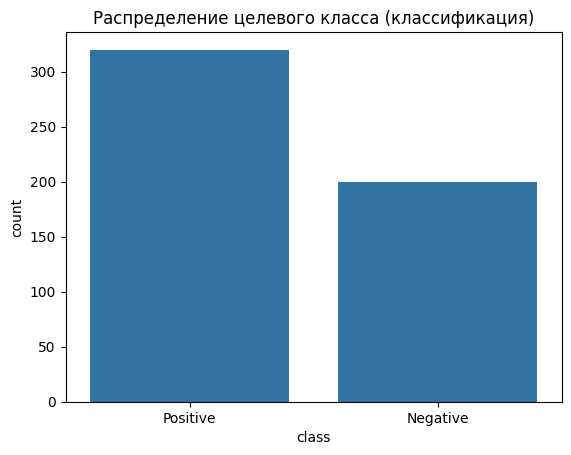

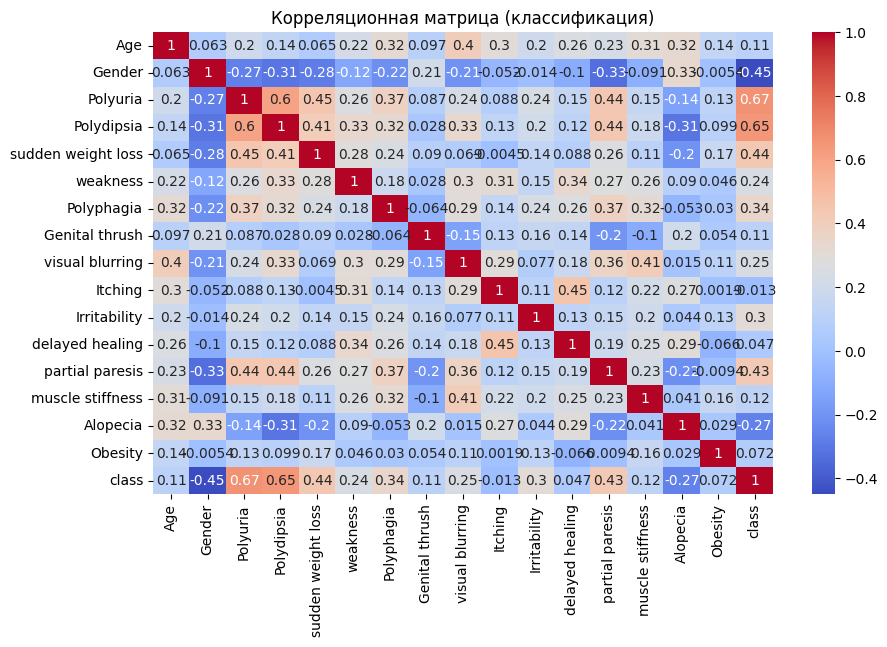

Уникальные значения в столбце brand: ['ASUS' 'Lenovo' 'acer' 'Avita' 'HP' 'DELL' 'MSI' 'APPLE']
Уникальные значения в столбце processor_brand: ['Intel' 'AMD' 'M1']
Уникальные значения в столбце processor_name: ['Core i3' 'Core i5' 'Celeron Dual' 'Ryzen 5' 'Core i7' 'Core i9' 'M1'
 'Pentium Quad' 'Ryzen 3' 'Ryzen 7' 'Ryzen 9']
Уникальные значения в столбце processor_gnrtn: ['10th' 'Not Available' '11th' '7th' '8th' '9th' '4th' '12th']
Уникальные значения в столбце ram_gb: ['4 GB' '8 GB' '16 GB' '32 GB']
Уникальные значения в столбце ram_type: ['DDR4' 'LPDDR4' 'LPDDR4X' 'DDR5' 'DDR3' 'LPDDR3']
Уникальные значения в столбце ssd: ['0 GB' '512 GB' '256 GB' '128 GB' '1024 GB' '2048 GB' '3072 GB']
Уникальные значения в столбце hdd: ['1024 GB' '0 GB' '512 GB' '2048 GB']
Уникальные значения в столбце os: ['Windows' 'DOS' 'Mac']
Уникальные значения в столбце os_bit: ['64-bit' '32-bit']
Уникальные значения в столбце graphic_card_gb: ['0 GB' '2 GB' '4 GB' '6 GB' '8 GB']
Уникальные значения в столб

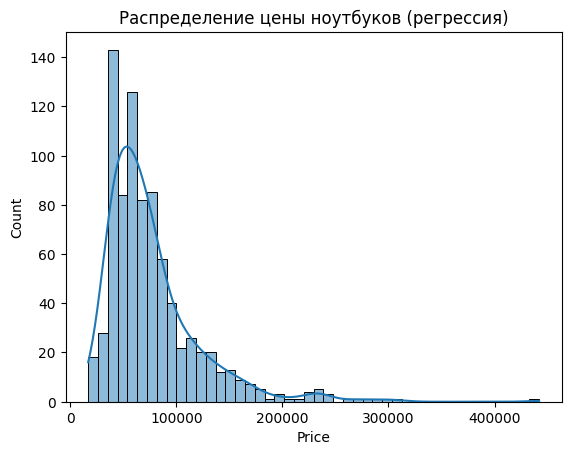

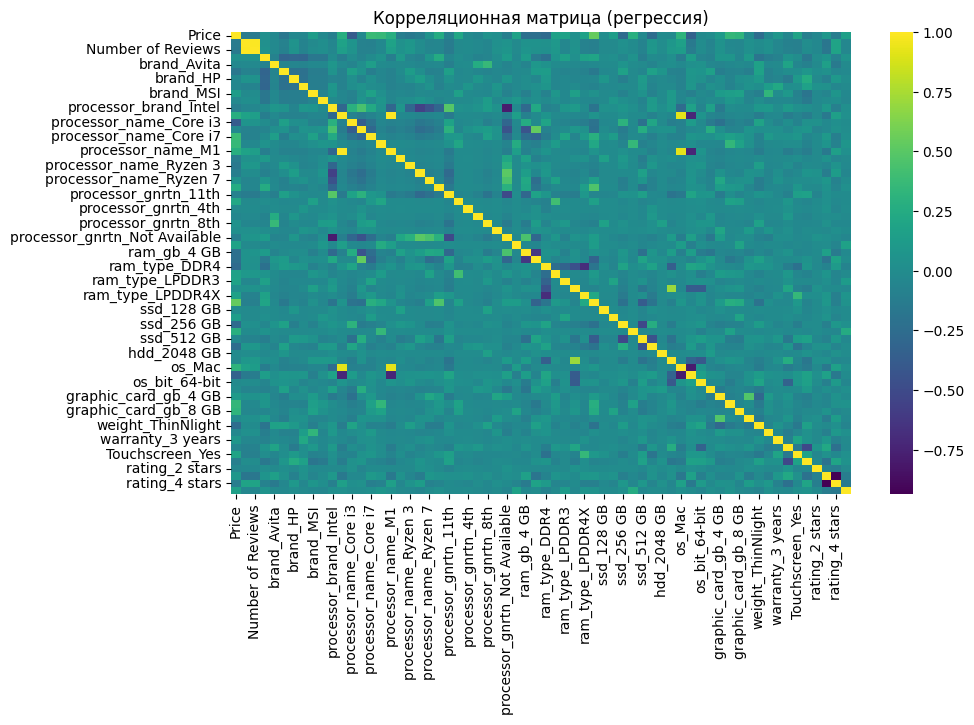

Визуализация данных завершена.


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- Визуализация для задачи классификации ---
# 1) Посмотрим на распределение целевого класса
sns.countplot(x='class', data=df_clf)
plt.title("Распределение целевого класса (классификация)")
plt.show()

# 2) Обработка строковых данных перед построением корреляционной матрицы
# Замена категорий "Yes", "No", "Male", "Female", и др.
df_clf_encoded = df_clf.replace({
    "Yes": 1,
    "No": 0,
    "Male": 1,
    "Female": 0,
    "Positive": 1,
    "Negative": 0
})

# Проверка оставшихся строковых значений
for col in df_clf_encoded.select_dtypes(include='object').columns:
    print(f"Уникальные значения в столбце {col}: {df_clf_encoded[col].unique()}")

# Преобразование оставшихся категориальных данных в числовые с помощью pd.get_dummies
df_clf_encoded = pd.get_dummies(df_clf_encoded, drop_first=True)

# Построение корреляционной матрицы
corr_clf = df_clf_encoded.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_clf, annot=True, cmap='coolwarm')
plt.title("Корреляционная матрица (классификация)")
plt.show()

# --- Визуализация для задачи регрессии ---
# 1) Обработка данных для регрессии
# Проверка строковых значений в df_reg
for col in df_reg.select_dtypes(include='object').columns:
    print(f"Уникальные значения в столбце {col}: {df_reg[col].unique()}")

# Преобразование категориальных данных в числовые
df_reg_encoded = pd.get_dummies(df_reg, drop_first=True)

# 2) Распределение целевой переменной 'Price'
sns.histplot(df_reg['Price'], kde=True)
plt.title("Распределение цены ноутбуков (регрессия)")
plt.show()

# 3) Корреляция признаков
corr_reg = df_reg_encoded.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr_reg, annot=False, cmap='viridis')
plt.title("Корреляционная матрица (регрессия)")
plt.show()

print("Визуализация данных завершена.")


Улучшение бейзлайна (Часть 2: Предобработка)

In [7]:
# Пример предобработки для классификации
df_clf = df_clf.replace({"Yes": 1, "No": 0})
X_clf = df_clf.drop("class", axis=1)
y_clf = df_clf["class"]

# Пример для регрессии (предположим, Price — целевая)
X_reg = df_reg.drop("Price", axis=1)
y_reg = df_reg["Price"]

print("Простая предобработка данных для ЛР №1 выполнена.")


Простая предобработка данных для ЛР №1 выполнена.


Создание бейзлайна (KNN)

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score
)

# --- Подготовка данных для классификации ---
# Предполагаем, что X_clf и y_clf содержат строковые данные
X_clf_encoded = pd.get_dummies(X_clf, drop_first=True)  # Преобразуем строковые столбцы в числовые
y_clf_encoded = pd.get_dummies(y_clf, drop_first=True)  # Если y_clf содержит строки

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf_encoded, y_clf_encoded, test_size=0.2, random_state=42
)

# Бейзлайн KNN (классификация)
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_clf, y_train_clf)
y_pred_clf = knn_clf.predict(X_test_clf)

accuracy = accuracy_score(y_test_clf, y_pred_clf)
precision = precision_score(y_test_clf, y_pred_clf, average='weighted')
recall = recall_score(y_test_clf, y_pred_clf, average='weighted')
f1 = f1_score(y_test_clf, y_pred_clf, average='weighted')

print("KNN (классификация, бейзлайн):")
print(f"Accuracy = {accuracy:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}, F1 = {f1:.3f}")

# --- Подготовка данных для регрессии ---
# Предполагаем, что X_reg и y_reg содержат строковые данные
X_reg_encoded = pd.get_dummies(X_reg, drop_first=True)  # Преобразуем строковые столбцы в числовые

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_encoded, y_reg, test_size=0.2, random_state=42
)

# Бейзлайн KNN (регрессия)
knn_reg = KNeighborsRegressor()
knn_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = knn_reg.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred_reg)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred_reg)

print("\nKNN (регрессия, бейзлайн):")
print(f"MSE = {mse:.3f}, RMSE = {rmse:.3f}, R2 = {r2:.3f}")


KNN (классификация, бейзлайн):
Accuracy = 0.856, Precision = 0.876, Recall = 0.856, F1 = 0.860

KNN (регрессия, бейзлайн):
MSE = 901714615.000, RMSE = 30028.563, R2 = 0.537


Улучшение бейзлайна (KNN: подбор параметров)

In [9]:
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

param_grid_clf = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"]
}
grid_clf = GridSearchCV(KNeighborsClassifier(), param_grid_clf, cv=5, scoring='f1')
grid_clf.fit(X_train_clf_scaled, y_train_clf)

best_knn_clf = grid_clf.best_estimator_
y_pred_clf_best = best_knn_clf.predict(X_test_clf_scaled)

f1_best = f1_score(y_test_clf, y_pred_clf_best)
print(f"Улучшенный KNN (классификация) F1 = {f1_best:.3f}, best_params = {grid_clf.best_params_}")

param_grid_reg = {
    "n_neighbors": [3, 5, 7],
    "weights": ["uniform", "distance"]
}
grid_reg = GridSearchCV(KNeighborsRegressor(), param_grid_reg, cv=5, scoring='neg_mean_squared_error')
grid_reg.fit(X_train_reg_scaled, y_train_reg)

best_knn_reg = grid_reg.best_estimator_
y_pred_reg_best = best_knn_reg.predict(X_test_reg_scaled)
mse_best = mean_squared_error(y_test_reg, y_pred_reg_best)
r2_best = r2_score(y_test_reg, y_pred_reg_best)

print(f"Улучшенный KNN (регрессия) MSE = {mse_best:.3f}, R2 = {r2_best:.3f}, best_params = {grid_reg.best_params_}")


Улучшенный KNN (классификация) F1 = 0.956, best_params = {'n_neighbors': 3, 'weights': 'distance'}
Улучшенный KNN (регрессия) MSE = 711839925.766, R2 = 0.635, best_params = {'n_neighbors': 5, 'weights': 'distance'}


Имплементация KNN "с нуля"

In [10]:
class CustomKNNClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = np.array(X)  # Убедимся, что это NumPy массив
        self.y_train = np.array(y).flatten()  # Преобразуем в одномерный массив

    def predict(self, X):
        predictions = []
        X = np.array(X)  # Убедимся, что это NumPy массив
        for x in X:
            distances = np.sqrt(((self.X_train - x) ** 2).sum(axis=1))
            neighbors_idx = distances.argsort()[:self.n_neighbors]
            neighbors_classes = self.y_train[neighbors_idx]
            majority_class = np.bincount(neighbors_classes).argmax()
            predictions.append(majority_class)
        return np.array(predictions)

# Создаем экземпляр кастомного KNN
custom_knn = CustomKNNClassifier(n_neighbors=3)

# Убедимся, что входные данные преобразованы в NumPy массивы
X_train_clf_scaled = np.array(X_train_clf_scaled)
X_test_clf_scaled = np.array(X_test_clf_scaled)
y_train_clf = np.array(y_train_clf)

# Обучаем и делаем предсказания
custom_knn.fit(X_train_clf_scaled, y_train_clf)
y_pred_custom = custom_knn.predict(X_test_clf_scaled)

# Оцениваем метрику F1
f1_custom = f1_score(y_test_clf, y_pred_custom, average='weighted')  # Для многоклассовых задач
print("Самостоятельная реализация KNN (классификация) F1:", f1_custom)


Самостоятельная реализация KNN (классификация) F1: 0.9057315233785823


# Выводы по Лабораторной работе №1:
1. Построили бейзлайн (KNN).
2. Добавили визуализацию (распределение целевой переменной, корреляции).
3. Улучшенный вариант (масштабирование + GridSearchCV) дал лучший результат.
4. Самостоятельная реализация KNN показала сопоставимую метрику (F1 ~ 0.906).
